<b>
<div style="text-align: center;">
<span style="font-size: 200%;">方策反復評価 (Iterative Policy Evaluation)</span>
</div>
</b>

<br>

<b>
<div style="text-align: right;">
    <span style="font-size: 150%;">
        2020/1/9 
    </span><br>
    <span style="font-size: 150%;">
        Masaya Mori
    </span>
</div>
</b>

# 目的

<span style="font-size: 120%;"> 今回は，状態価値を『再帰処理』で導出した場合と『反復処理』で求めた場合の計算速度の違いを比較する．</span>  
<span style="font-size: 120%;"> 問題設定などは『[状態価値関数](https://github.com/rrrrind/reinforcement-learning/blob/master/DP/src/State%20Value%20Function/State_Value_Function.ipynb)』『[行動価値関数](https://github.com/rrrrind/reinforcement-learning/blob/master/DP/src/Action%20Value%20Function/Action_Value_Function.ipynb)』の時と同じである．
</span>

# Pythonでの実装

## 再帰処理の場合

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time

In [7]:
stage = [[0,4],[1,4],[2,4],[3,4],[4,4],
         [0,3],[1,3],[2,3],[3,3],[4,3],
         [0,2],[1,2],[2,2],[3,2],[4,2],
         [0,1],[1,1],[2,1],[3,1],[4,1],
         [0,0],[1,0],[2,0],[3,0],[4,0]]

In [16]:
# 状態価値-時間 のグラフを作る
count = 11
time_holder = np.zeros([count+1,25])
result_holder = np.zeros([count+1,25])
temp_holder = np.zeros([count+1,25])

In [17]:
class Agent(): # stage_map, the array number of the stage    
    
    def __init__(self):
        # 行動a,方策πの宣言。引数で使うので、初めに宣言する。
        self.actions = [[0,1],[0,-1],[-1,0],[1,0]] # up,down,left,right
        self.each_pi = [0.25,0.25,0.25,0.25]
        self.position = []
    
    def set_pos(self,now_pos):
        # 現在地の更新
        self.position = now_pos
        
    def get_pos(self):
        # 現在地の取得
        return self.position
    
    def move(self,action):
        # 行動後の位置の取得
        if self.get_pos() == [1,4]: # 10ptゾーン
            next_pos = [1,0]
        elif self.get_pos() == [3,4]: # 5ptゾーン
            next_pos = [3,2]
        else :
            next_pos = [self.get_pos()[0] + action[0], self.get_pos()[1] + action[1]]
        
        # 境界線外に出ている時の処理
        if 0 > next_pos[0] or next_pos[0] > 4 or 0 > next_pos[1] or next_pos[1] > 4:
            next_pos = self.get_pos()
            
        self.set_pos(next_pos)
    
    def pi(self,state,num):
        return self.each_pi[num]
        
    def reward(self,state,action):
        if state == [1,4]:
            return 10
        
        if state == [3,4]:
            return 5
        
        if state[1] == 4 and action == [0,1]:
            return -1
        elif state[1] == 0 and action == [0,-1]:
            return -1
        elif state[0] == 0 and action == [-1,0]:
            return -1
        elif state[0] == 4 and action == [1,0]:
            return -1
        else :
            return 0
    
    def v_pi(self,state,n,out,iter_num,stage_num): # この"state"は，潜った時の位置を記憶しておくため
        if n == iter_num :
            start = time.time()
            for i, action in enumerate(self.actions):
                # 最下層での処理．最下層では前後左右に動いた際の報酬を一気に計算する．
                out += self.pi(state,i) * self.reward(state,action)
            elapsed_time = time.time() - start
            temp_holder[n,stage_num] = elapsed_time
            return out
        else :
            start = time.time()
            for i, action in enumerate(self.actions):              
                # 先に π*R を計算し，action方向に移動する
                out += self.pi(self.get_pos(),i) * self.reward(self.get_pos(),action)
                self.move(action)
                # この時、"state"は1つ前の位置，"self.get_pos()"には現在の位置が記憶されている
                # 移動後，つまり現在の状態はs'となっているので，s'の報酬を計算する
                out += self.pi(self.get_pos(),i) * 0.9 * self.v_pi(self.get_pos(), n+1, 0, iter_num, stage_num)
                # ここで再帰関数を使っているので，"n"が"iter_num"と同じ回数
                # つまり，指定した深さまで潜らないと次のプログラムへ進むことはできない
                self.set_pos(state) # "self.get_pos()"から1つ前の状態"state"に戻るため  
            elapsed_time = time.time() - start
            temp_holder[n,stage_num] = elapsed_time
            return out

In [18]:
agent = Agent()
v_pi_value = []

start = time.time()
for i,locate in tqdm(enumerate(stage)):
    agent.set_pos(locate)
    v_pi_value.append(agent.v_pi(agent.get_pos(),0,0,count,i))
    time_holder[:,i] = temp_holder[:,i][::-1]
    for j in range(count+1):
        result_holder[j,i] = agent.v_pi(agent.get_pos(),0,0,j,i)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


elapsed_time:170.18823099136353[sec]


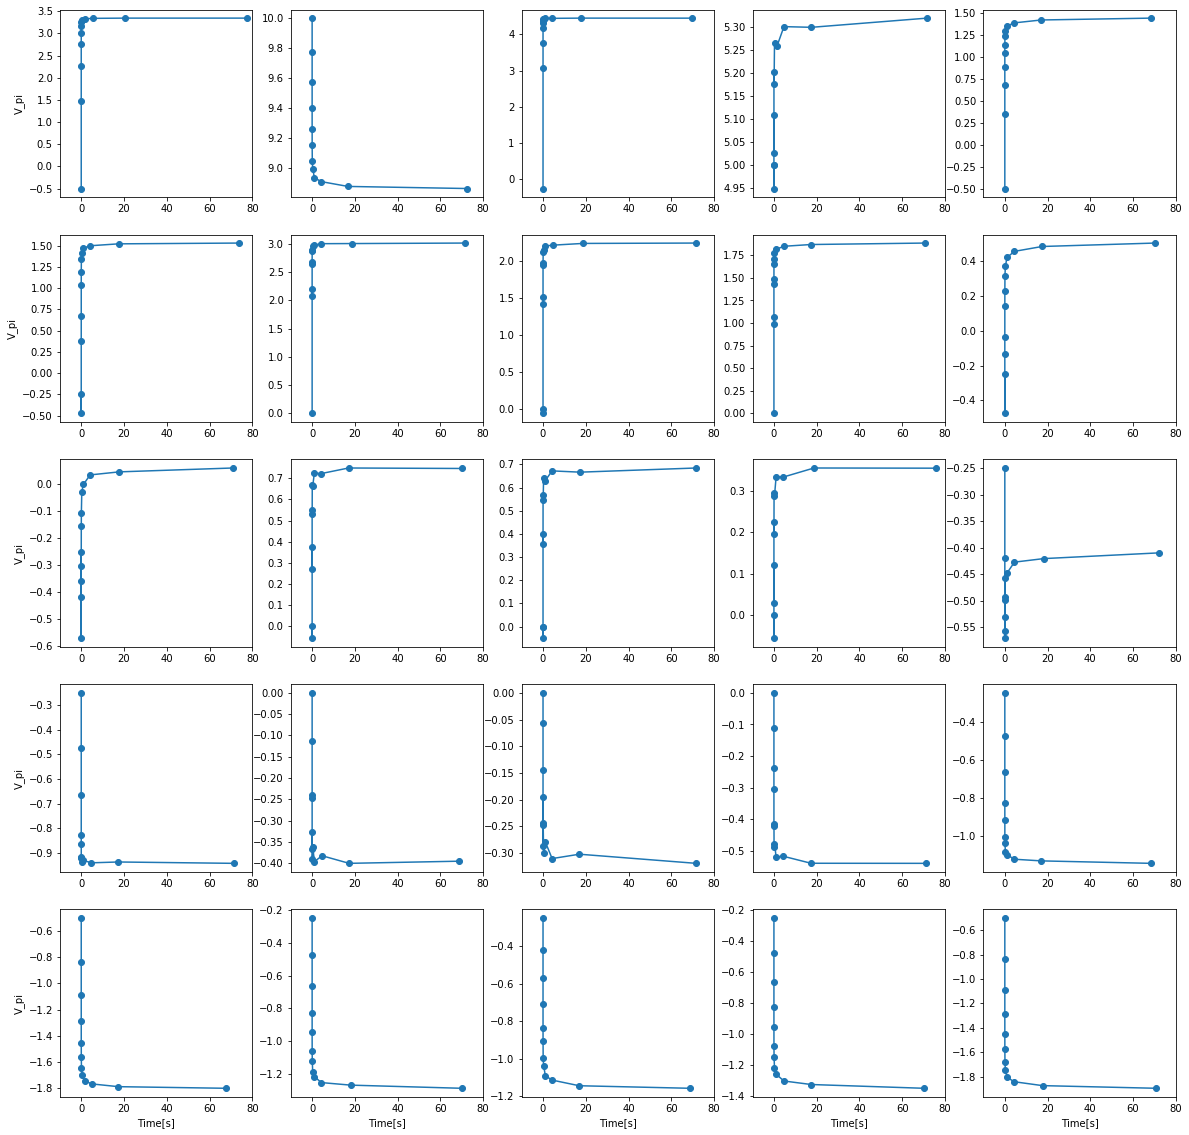

In [338]:
# グラフの表示
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for graph_num in range(25):
    plt.subplot(5,5,graph_num+1)
    plt.plot(time_holder[:,graph_num],result_holder[:,graph_num], marker="o")  
    plt.xlim(-10,80)
    if graph_num % 5 == 0:
        plt.ylabel("V_pi")
    if graph_num >= 20: 
        plt.xlabel("Time[s]")

plt.show()
fig.savefig("figure/recursive_processing.jpg")

## 反復処理の場合

<span style="font-size: 120%;">反復処理による近似を行う．このアルゴリズムを『<span style="color: red; ">方策反復評価(Iterative Policy Evaluation)</span>』という．</span>

In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [12]:
# 状態価値-時間 のグラフを作る
N = 100
times = np.zeros(N)
results = np.zeros([N,25])

In [13]:
stage = [[0,4],[1,4],[2,4],[3,4],[4,4],
         [0,3],[1,3],[2,3],[3,3],[4,3],
         [0,2],[1,2],[2,2],[3,2],[4,2],
         [0,1],[1,1],[2,1],[3,1],[4,1],
         [0,0],[1,0],[2,0],[3,0],[4,0]]

In [14]:
class Agent(): # stage_map, the array number of the stage    
    
    def __init__(self):
        # 行動a,方策πの宣言。引数で使うので、初めに宣言する。
        self.actions = [[0,1],[0,-1],[-1,0],[1,0]] # up,down,left,right
        self.each_pi = [0.25,0.25,0.25,0.25]
        # 現在の価値関数と一つ先の価値関数も持たせよう!
        self.V_pi = np.zeros(25)
        self.Vs_pi = np.zeros(25)
        self.position = []
    
    def set_pos(self,now_pos):
        # 現在地の更新
        self.position = now_pos
        
    def get_pos(self):
        # 現在地の取得
        return self.position
    
    def move(self,action):
        # 行動後の位置の取得
        if self.get_pos() == [1,4]: # 10ptゾーン
            next_pos = [1,0]
        elif self.get_pos() == [3,4]: # 5ptゾーン
            next_pos = [3,2]
        else :
            next_pos = [self.get_pos()[0] + action[0], self.get_pos()[1] + action[1]]
        
        # 境界線外に出ている時の処理
        if 0 > next_pos[0] or next_pos[0] > 4 or 0 > next_pos[1] or next_pos[1] > 4:
            next_pos = self.get_pos()
            
        self.set_pos(next_pos)
    
    def pi(self,state,num):
        return self.each_pi[num]
        
    def reward(self,state,action):
        if state == [1,4]:
            return 10
        
        if state == [3,4]:
            return 5
        
        if state[1] == 4 and action == [0,1]:
            return -1
        elif state[1] == 0 and action == [0,-1]:
            return -1
        elif state[0] == 0 and action == [-1,0]:
            return -1
        elif state[0] == 4 and action == [1,0]:
            return -1
        else :
            return 0
    
    def v_pi(self,stage):
        self.V_pi = np.zeros(25)
        for i, _ in enumerate(self.V_pi):
            self.set_pos(stage[i])
            state = self.get_pos()
            for j, action in enumerate(self.actions): 
                self.V_pi[i] += self.pi(self.get_pos(),j) * self.reward(self.get_pos(),action)
                self.move(action)
                self.V_pi[i] += self.pi(self.get_pos(),j) * 0.9 * self.Vs_pi[stage.index(self.get_pos())]
                self.set_pos(state)
        self.Vs_pi = self.V_pi
        return self.V_pi

In [15]:
agent = Agent()

start = time.time()
for i in tqdm(range(N)):
    results[i] = agent.v_pi(stage)
    times[i] = time.time() - start
times = times / 25

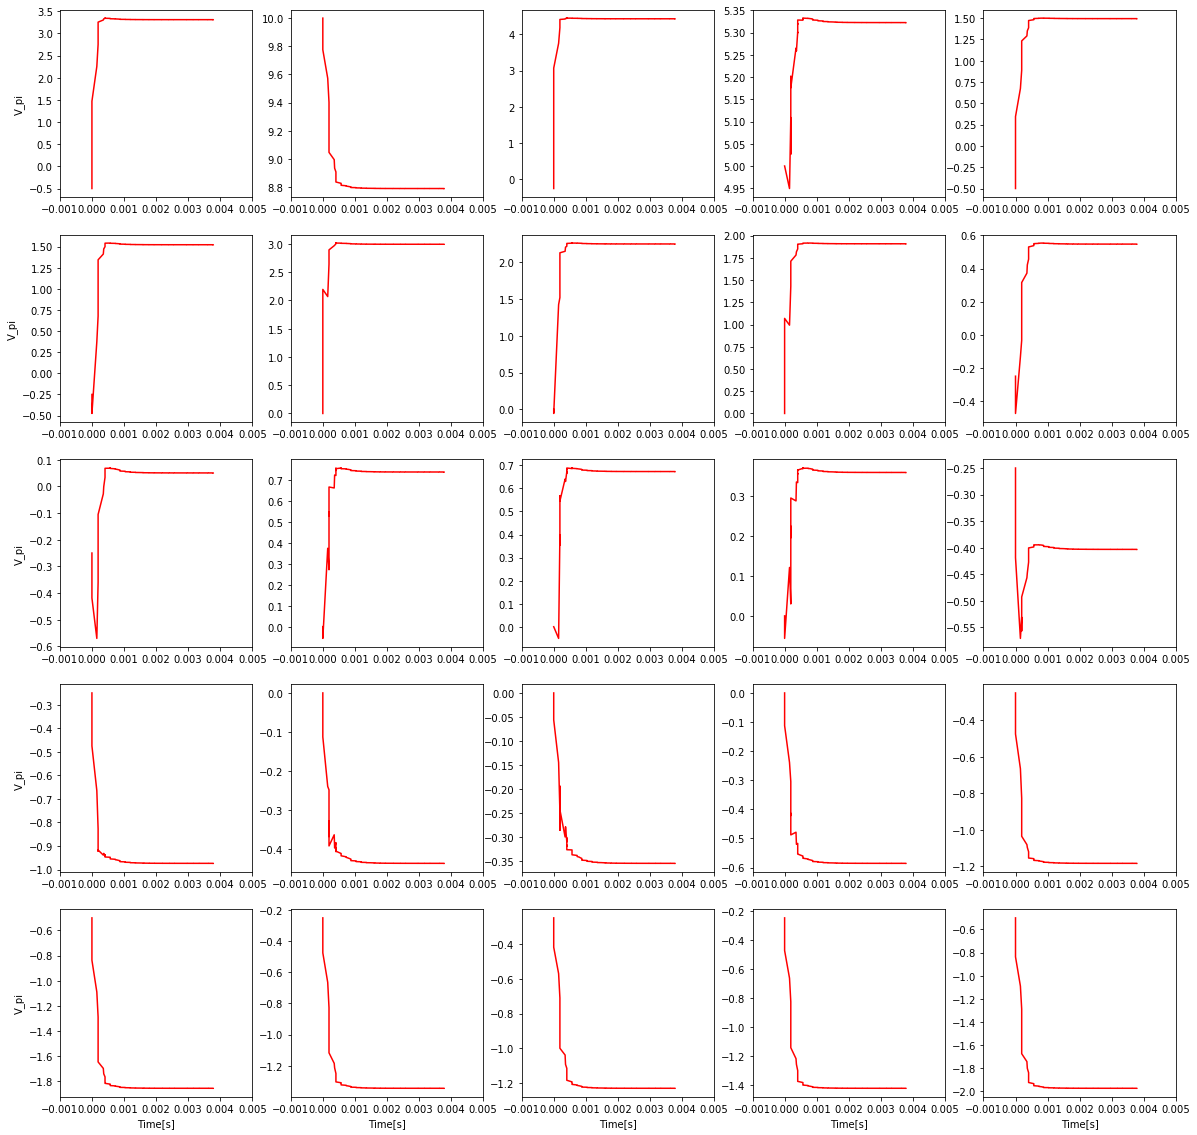

In [455]:
# グラフの表示
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for graph_num in range(25):
    plt.subplot(5,5,graph_num+1)
    plt.plot(times,results[:,graph_num], color="red")  
    plt.xlim(-0.001,0.005)
    if graph_num % 5 == 0:
        plt.ylabel("V_pi")
    if graph_num >= 20: 
        plt.xlabel("Time[s]")

plt.show()
fig.savefig("figure/iterative_processing.jpg")

# 結果・まとめ

![まとめ](figure/result.jpg)

- <span style="font-size: 120%;"> 再帰処理の場合，10回の再帰処理で約20秒，11回の再帰処理で約70秒という結果となった</span>  
<span style="font-size: 120%;"> ついでに，11回の再帰処理は$4^{11}=4,194,304$通りの組み合わせが存在する </span>  
- <span style="font-size: 120%;"> 反復処理の場合，100回の反復処理で約0,004秒という結果となった</span>  

<span style="font-size: 120%;"> → これらの結果から，再帰処理から反復処理に変更するだけで<span style="color: red; ">約17,500倍計算速度が速くなる</span>ことが確認できた．</span>  

## 参考資料

- [今さら聞けない強化学習（5）：状態価値関数近似と方策評価](https://qiita.com/triwave33/items/bed0fd7a2b56ee8e7c29)
- [強化学習：再帰処理と反復処理](https://shirakonotempura.hatenablog.com/entry/2019/01/31/070932)